In [1]:
import copy
import itertools
import numpy as np
import h5py
import scipy
import sys
import tqdm
import verdict
import os
import unyt

In [2]:
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import palettable

In [3]:
import kalepy as kale

In [4]:
import galaxy_dive.analyze_data.halo_data as halo_data
import galaxy_dive.plot_data.plotting as plotting

In [5]:
import trove
import trove.config_parser

# Load Data

In [6]:
config_fp = '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove'
cp = trove.config_parser.ConfigParser( config_fp )
pm = trove.link_params_to_config(
    config_fp,
    variation = 'm12i_md',
)

In [7]:
data_filepath = os.path.join( pm['processed_data_dir'], 'summary.hdf5' )
data = verdict.Dict.from_hdf5( data_filepath )

# Plot PDFs

In [9]:
sims_to_plot = [ 'm12i_md', 'm12c_md', 'm11d_md' ]

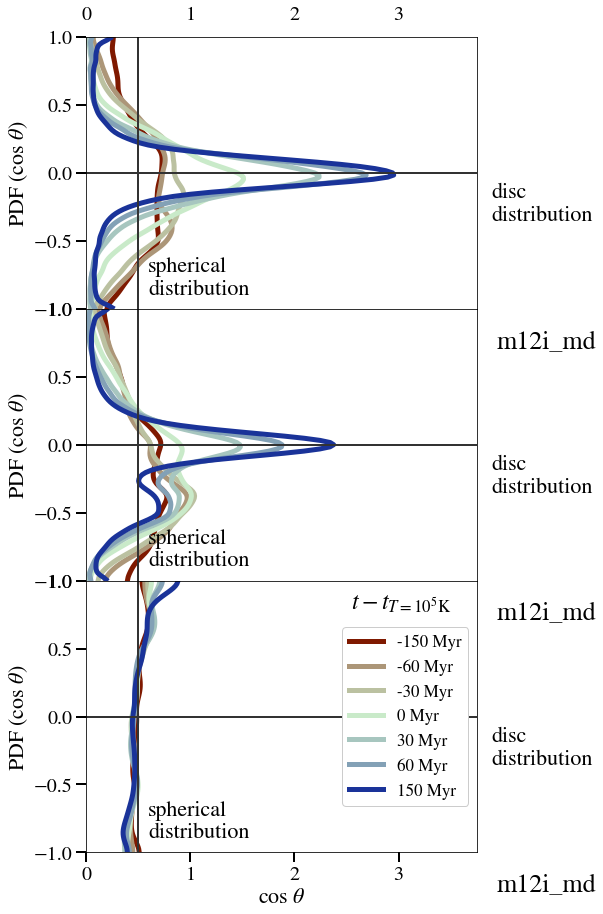

In [25]:
n_rows = len( sims_to_plot )

fig = plt.figure( figsize=(7,5*n_rows), facecolor='w' )
main_ax = plt.gca()

gs = gridspec.GridSpec( n_rows, 1 )
gs.update( hspace=0.0001 )

for j, sim in enumerate( sims_to_plot ):
    
    ax = plt.subplot( gs[j,0] )
    
    pdfs = data['cosphi']['pdf'][sim]
    centers = data['cosphi']['points'][sim]
    t_t1e5_centers = data['cosphi']['t_t1e5_centers'][sim]
    z_max = t_t1e5_centers.max()
    z_min = t_t1e5_centers.min()
        
    for i, pdf in enumerate( pdfs ):

        z_width = z_max - z_min
        color_value = ( t_t1e5_centers[i] - z_min )/z_width
        color = palettable.scientific.diverging.Roma_3.mpl_colormap( color_value )

        if np.isclose( t_t1e5_centers[i], 0. ):
            t_t1e5_centers[i] = 0
#             label = (
#                 r'$t - t_{T=10^5 {\rm K}}$ =' +
#                 ' {:.3g}'.format( t_tphase_centers[i]*1e3 ) +
#                 r' Myr'
#             )
        label = (
            '{:.3g}'.format( t_t1e5_centers[i]*1e3 ) +
            r' Myr'
        )

        line = ax.plot(
            pdf,
            centers,
            linewidth = 5,
            color = color,
            label = label,
    #             zorder = 10 - i,
        )

    ax.tick_params(
        axis = 'x',
        bottom = ax.is_last_row(),
        labeltop = ax.is_first_row(),
        labelbottom = ax.is_last_row(),
    )

    ax.axvline(
        0.5,
        color = '.2',
        linestyle = '-',
        linewidth = 2,
    )
    ax.axhline(
        0,
        color = '.2',
        linestyle = '-',
        linewidth = 2,
    )

    # Sim name label
    ax.annotate(
        s = pm['variation'],
        xy = ( 1, 0 ),
        xycoords = 'axes fraction',
        xytext = ( 20, -20 ),
        textcoords = 'offset points',
        ha = 'left',
        va = 'top',
        fontsize = 26,
    )

    # line labels
    ax.annotate(
        s = 'spherical\ndistribution',
        xy = ( 0.5, -1 ),
        xycoords = 'data',
        xytext = ( 10, 10 ),
        textcoords = 'offset points',
        ha = 'left',
        va = 'bottom',
        fontsize = 22,
    )
    ax.annotate(
        s = 'disc\ndistribution',
        xy = ( 3.75, 0 ),
        xycoords = 'data',
        xytext = ( 15, -10 ),
        textcoords = 'offset points',
        ha = 'left',
        va = 'top',
        fontsize = 22,
    )

    if ax.is_last_row():
        t_label = ax.annotate(
            s = r'$t - t_{T=10^5 {\rm K}}$',
            xy = ( 1, 0.875 ),
            xycoords = 'axes fraction',
            xytext = ( -25, 0 ),
            textcoords = 'offset points',
            ha = 'right',
            va = 'bottom',
            fontsize = 24,
        )
        t_label.set_zorder( 1000 )
        ax.legend(
            prop={'size': 17},
            loc = 'center right',
            framealpha=1,
        )

    ax.set_xlim( 0, 3.75 )
    ax.set_ylim( -1, 1 )

    if ax.is_last_row():
        ax.set_xlabel( r'$\cos\ \theta$', fontsize=22 )

    ax.set_ylabel( r'PDF$\ (\cos\ \theta$)', fontsize=22 )